In [1]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# Analysis

In [2]:
data = pd.read_csv('data/train.csv')
print(data.shape)
data.head()

(1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Target

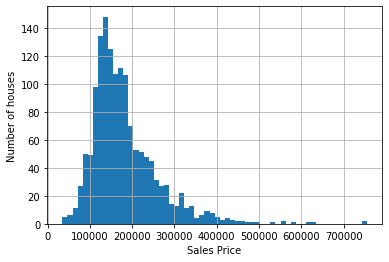

In [3]:
data['SalePrice'].hist(bins=60)
plt.ylabel('Number of houses')
plt.xlabel('Sales Price')
plt.show()

Target distribiution is skewed towards right. I can try to improve it using logarithmic transformation.

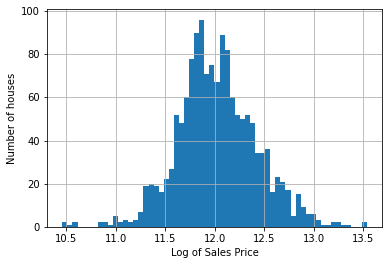

In [4]:
np.log(data['SalePrice']).hist(bins=60)
plt.ylabel('Number of houses')
plt.xlabel('Log of Sales Price')
plt.show()

Gaussian-ish distribiution is usally better for models.

## Variable Types

In [5]:
categorical = [col for col in data.columns if data[col].dtype == 'O'] #check for type *object*
#from Kaggle definitions of variables, I know that MSSubClass is also categorical
categorical += ['MSSubClass']
data[categorical] = data[categorical].astype('O')
print(f'Number of categorical: {len(categorical)}')

Number of categorical: 44


In [6]:
numerical = [col for col in data.columns if col not in categorical and col != 'SalePrice']
print(f'Number of numerical: {len(numerical)}') 

Number of numerical: 36


## Missing Values

In [9]:
cols_with_na = [col for col in data.columns if data[col].isnull().sum()>0]
data[cols_with_na].isnull().mean().sort_values(ascending=False)

PoolQC          0.995205
MiscFeature     0.963014
Alley           0.937671
Fence           0.807534
FireplaceQu     0.472603
LotFrontage     0.177397
GarageType      0.055479
GarageYrBlt     0.055479
GarageFinish    0.055479
GarageQual      0.055479
GarageCond      0.055479
BsmtExposure    0.026027
BsmtFinType2    0.026027
BsmtFinType1    0.025342
BsmtCond        0.025342
BsmtQual        0.025342
MasVnrArea      0.005479
MasVnrType      0.005479
Electrical      0.000685
dtype: float64

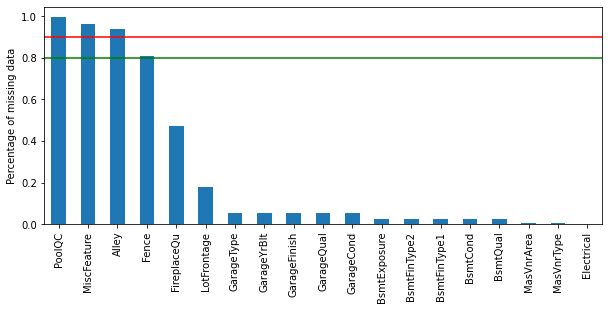

In [14]:
data[cols_with_na].isnull().mean().sort_values(ascending=False).plot.bar(figsize=(10,4))
plt.ylabel('Percentage of missing data')
plt.axhline(y=0.9,color='r',linestyle='-')
plt.axhline(y=0.8,color='g',linestyle='-')
plt.show()

In [16]:
categorical_with_na = [col for col in categorical if col in cols_with_na]
numerical_with_na = [col for col in numerical if col in cols_with_na]
print('Number of categorical cols with na: {}\n \
Number of numerical cols with na: {}'.format(len(categorical_with_na),len(numerical_with_na)))

Number of categorical cols with na: 16
Number of numerical cols with na: 3


In [18]:
categorical_with_na

['Alley',
 'MasVnrType',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Electrical',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PoolQC',
 'Fence',
 'MiscFeature']

In [19]:
numerical_with_na

['LotFrontage', 'MasVnrArea', 'GarageYrBlt']

#### Relation between missing values and target

In [23]:
def analyze_col(col: str, df: pd.DataFrame):
    df = df.copy()
    df[col] = np.where(df[col].isnull(), 1, 0)
    tmp = df.groupby(col)['SalePrice'].agg(['mean','std'])
    tmp.plot(kind='barh', y='mean', xerr='std', title='Sale Price', color='green', legend=False)
    plt.show()

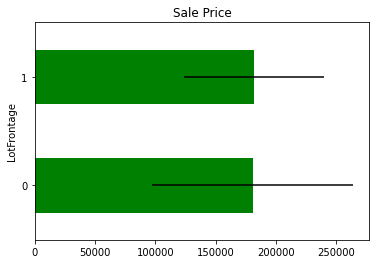

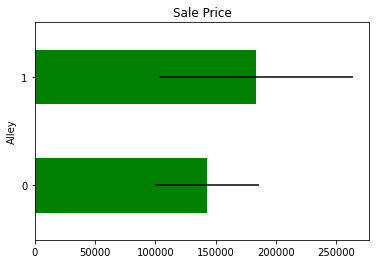

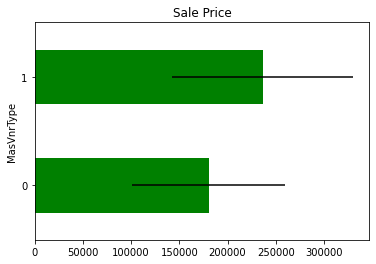

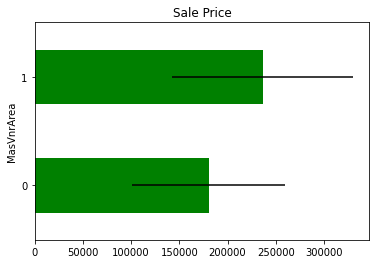

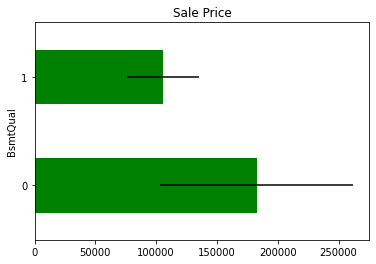

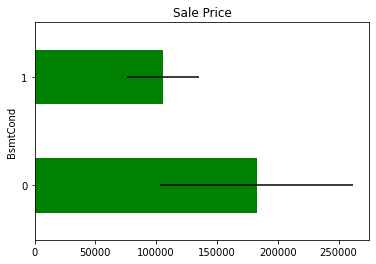

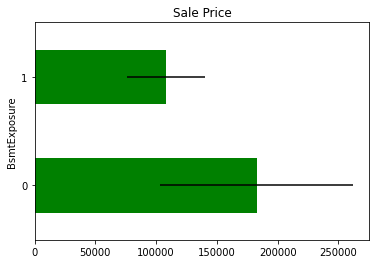

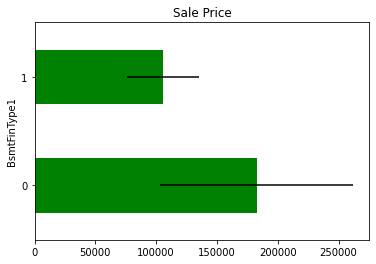

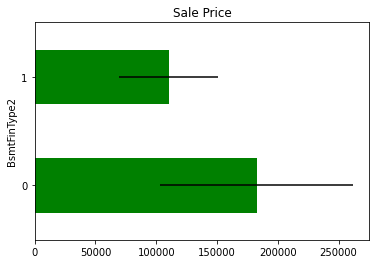

c:\Users\SZYMON\Documents\Python Scripts\App\.venv\lib\site-packages\numpy\core\_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
c:\Users\SZYMON\Documents\Python Scripts\App\.venv\lib\site-packages\numpy\core\_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


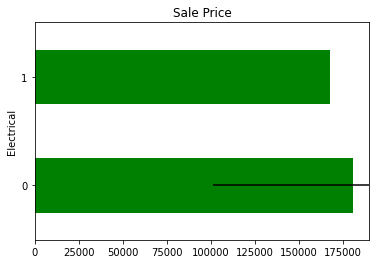

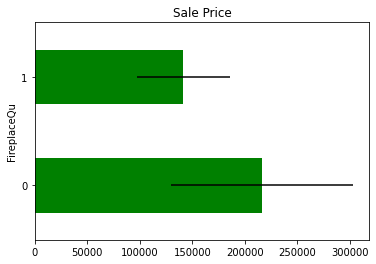

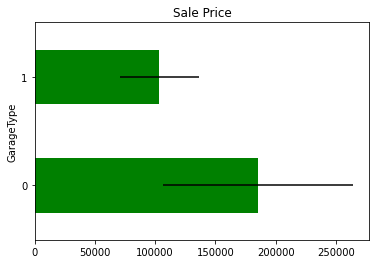

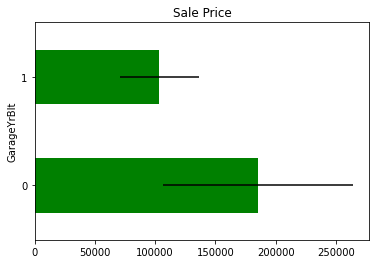

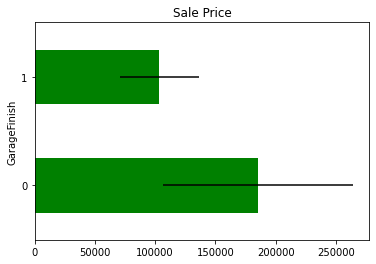

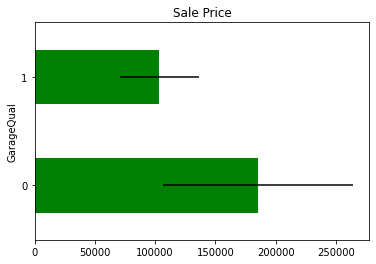

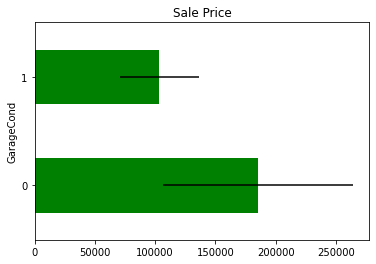

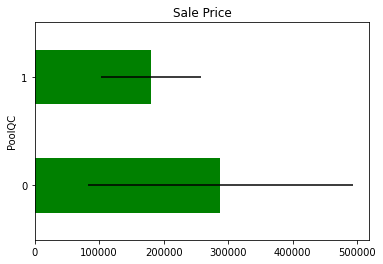

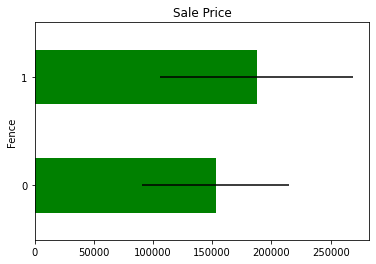

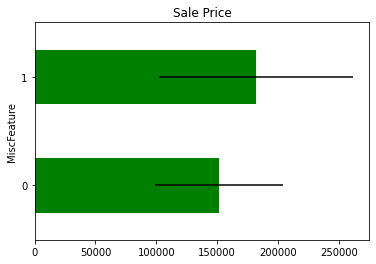

In [24]:
for col in cols_with_na:
    analyze_col(col, data)

In some columns, average SalePrice where data is missing, differs from average SalePrice in houses where data exists. This suggests that data being missing could be a good predictor of SalePrice.

## Numerical Variables

In [25]:
print('Number of numerical cols: ', len(numerical))

data[numerical].head()

Number of numerical cols:  36


,Id,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,1,65.0,8450,7,5,2003,2003,196.0,706,0,...,548,0,61,0,0,0,0,0,2,2008
1,2,80.0,9600,6,8,1976,1976,0.0,978,0,...,460,298,0,0,0,0,0,0,5,2007
2,3,68.0,11250,7,5,2001,2002,162.0,486,0,...,608,0,42,0,0,0,0,0,9,2008
3,4,60.0,9550,7,5,1915,1970,0.0,216,0,...,642,0,35,272,0,0,0,0,2,2006
4,5,84.0,14260,8,5,2000,2000,350.0,655,0,...,836,192,84,0,0,0,0,0,12,2008


### Temporal variables

In [26]:
year_vars = [var for var in numerical if 'Yr' in var or 'Year' in var]

year_vars

['YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'YrSold']

In [27]:
for var in year_vars:
    print(var, data[var].unique())

YearBuilt [2003 1976 2001 1915 2000 1993 2004 1973 1931 1939 1965 2005 1962 2006
 1960 1929 1970 1967 1958 1930 2002 1968 2007 1951 1957 1927 1920 1966
 1959 1994 1954 1953 1955 1983 1975 1997 1934 1963 1981 1964 1999 1972
 1921 1945 1982 1998 1956 1948 1910 1995 1991 2009 1950 1961 1977 1985
 1979 1885 1919 1990 1969 1935 1988 1971 1952 1936 1923 1924 1984 1926
 1940 1941 1987 1986 2008 1908 1892 1916 1932 1918 1912 1947 1925 1900
 1980 1989 1992 1949 1880 1928 1978 1922 1996 2010 1946 1913 1937 1942
 1938 1974 1893 1914 1906 1890 1898 1904 1882 1875 1911 1917 1872 1905]
YearRemodAdd [2003 1976 2002 1970 2000 1995 2005 1973 1950 1965 2006 1962 2007 1960
 2001 1967 2004 2008 1997 1959 1990 1955 1983 1980 1966 1963 1987 1964
 1972 1996 1998 1989 1953 1956 1968 1981 1992 2009 1982 1961 1993 1999
 1985 1979 1977 1969 1958 1991 1971 1952 1975 2010 1984 1986 1994 1988
 1954 1957 1951 1978 1974]
GarageYrBlt [2003. 1976. 2001. 1998. 2000. 1993. 2004. 1973. 1931. 1939. 1965. 2005.
 1962. 2006.

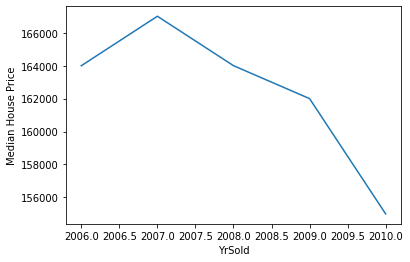

In [29]:
#median sale price vs year in which it was sold
data.groupby('YrSold')['SalePrice'].median().plot()
plt.ylabel('Median House Price')
plt.show()

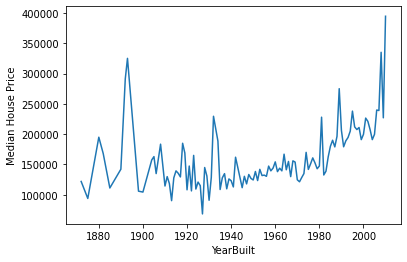

In [30]:
#median sale price vs year in which it was built
data.groupby('YearBuilt')['SalePrice'].median().plot()
plt.ylabel('Median House Price')
plt.show()

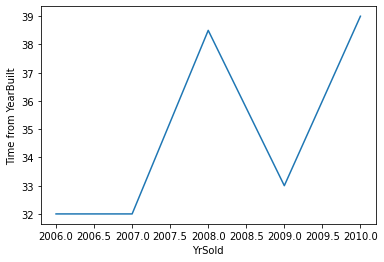

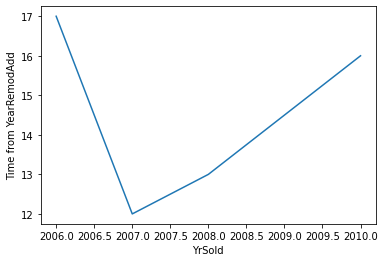

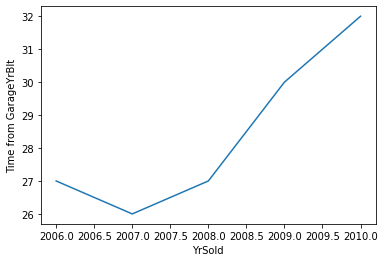

In [36]:
def analyse_year_cols(col: str, df: pd.DataFrame):
    
    df = df.copy()
    df[col] = df['YrSold'] - df[col]

    df.groupby('YrSold')[col].median().plot()
    plt.ylabel('Time from ' + col)
    plt.show()
    
for col in year_vars:
    if col !='YrSold':
        analyse_year_cols(col, data)

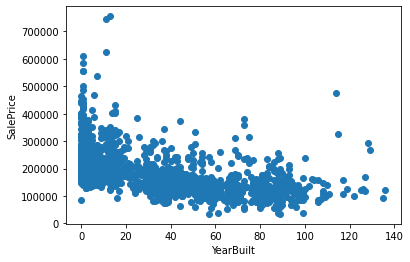

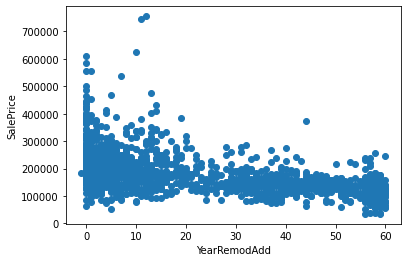

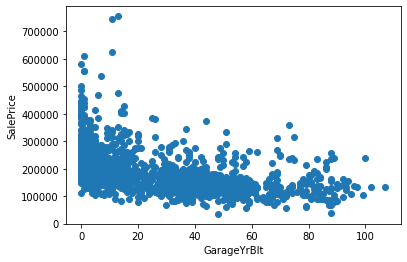

In [39]:
def analyse_year_cols(col: str, df: pd.DataFrame):
    
    df = df.copy()
    
    df[col] = df['YrSold'] - df[col]
    
    plt.scatter(df[col], df['SalePrice'])
    plt.ylabel('SalePrice')
    plt.xlabel(col)
    plt.show()
    
for col in year_vars:
    if col !='YrSold':
        analyse_year_cols(col, data)

 There is a tendency to a decrease in price, with older houses. In other words, the longer the time between the house was built or remodeled and sale date, the lower the sale Price.
### Dicrete variables

In [41]:
discrete_cols = [var for var in numerical if len(data[var].unique()) < 20 and var not in year_vars]

print('Number of discrete variables: ', len(discrete_cols))
data[discrete_cols].head()

Number of discrete variables:  13


,OverallQual,OverallCond,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,PoolArea,MoSold
0,7,5,1,0,2,1,3,1,8,0,2,0,2
1,6,8,0,1,2,0,3,1,6,1,2,0,5
2,7,5,1,0,2,1,3,1,6,1,2,0,9
3,7,5,1,0,1,0,3,1,7,1,3,0,2
4,8,5,1,0,2,1,4,1,9,1,3,0,12


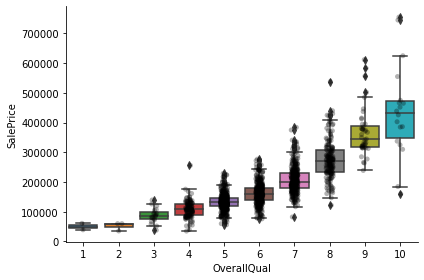

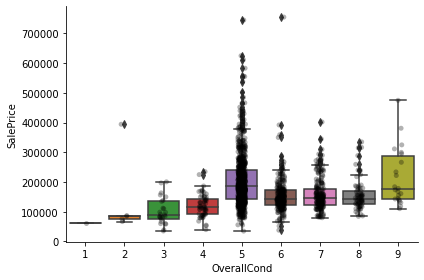

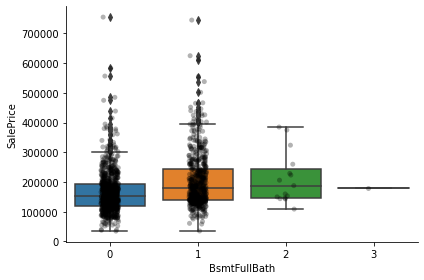

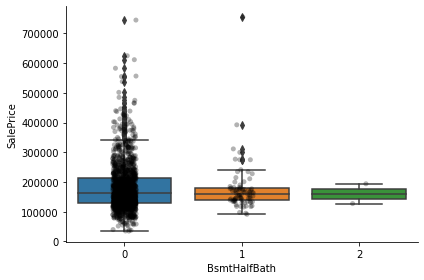

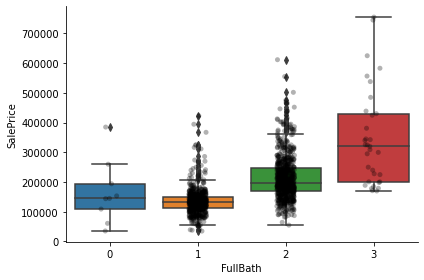

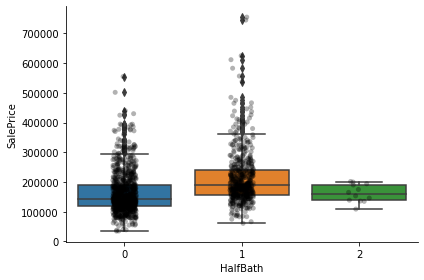

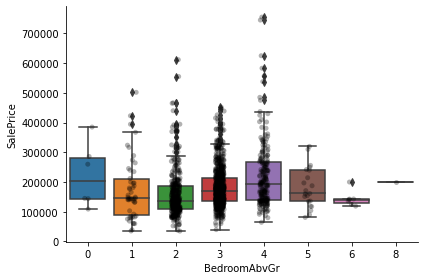

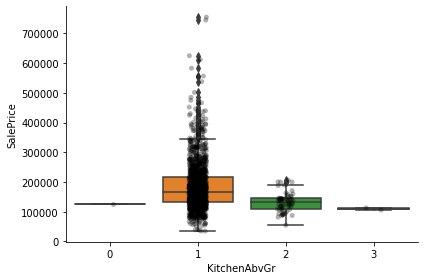

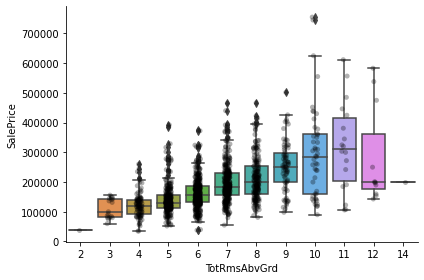

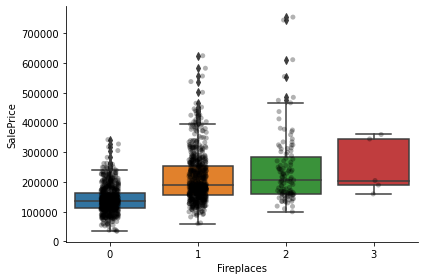

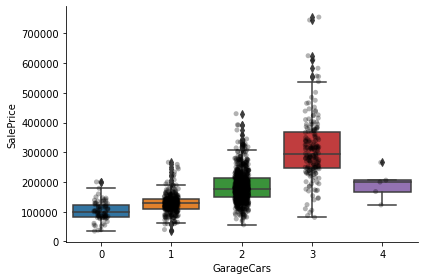

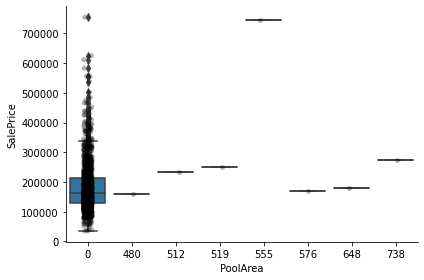

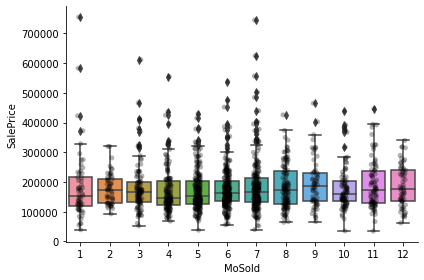

In [43]:
for col in discrete_cols:
    sns.catplot(x=col, y='SalePrice', data=data, kind="box", height=4, aspect=1.5)
    sns.stripplot(x=col, y='SalePrice', data=data, jitter=0.1, alpha=0.3, color='k')
    plt.show()